### <center>**Assignment**</center>

### Goal
Predict the presence or absence of cardiac arrhythmia in a patient

### Read this note carefully

- Submit to **eeclass** with your code file, the filename format should be Lab06_{student_id}.ipynb. The notebook should contain
    1. Loading of dataset
    2. Splitting of dataset to training and testing data (test_size = 20% of the whole dataset)
    3. Building of a self-designed Logistic Regression model (Complete the TODO parts provided below)
    4. Plotting the loss curve.
    5. Plotting of the confusion matrix. (**Label 0 as positive**)
    6. Computing the F1-score of this confusion matrix. The F1-score should be at least 0.75
- Deadline: **2023-10-26(Thr) 23:59**
- Please make sure that we can rerun your code


In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.10.12
import os
import math

from IPython.display import Image
from IPython.display import display

# numpy 1.23.5
import numpy as np

# pandas 1.5.3
import pandas as pd

# scikit-learn 1.2.2
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
# from cycler import cycler

# matplotlib  3.7.1
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

### Dataset

The [Arrhythmia](https://archive.ics.uci.edu/ml/datasets/Arrhythmia) dataset from UCI repository contains 280 variables collected from 452 patients. Its information helps in distinguishing between the presence and absence of cardiac arrhythmia and in classifying arrhytmia in one of the 16 groups. In this homework, we will just focus on building a Logistic Regression model that can classify between the presence and absence of arrhythmia.

Original class 1 refers to 'normal' ECG which we will regard as 'absence of arrhythmia' and the rest of the classes will be 'presence of arrhythmia'.

In [2]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


How big is the dataset?

In [3]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


The last column of the dataset is the class label. It contains the 16 ECG classifications:

In [4]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

Let's make that column (class label) dichotomous.

Value is 0 if ECG is normal, 1 otherwise

In [5]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

Are the groups balanced?

In [6]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

Some columns have missing values denoted as '?'

To make the preprocessing simpler, let's just retain the columns with numeric values.


In [7]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [8]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [9]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [10]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(361, 274)
(361,)
(91, 274)
(91,)


In [11]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Please continue working from here.


In [12]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            self.w_[1:] += self.eta * gradient_weights
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
            if(i % 100 == 0): print(f"[Epochs {i}/{self.n_epoch}]: cost = {cost}")
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""
        # TODO
        epsilon = 1e-15
        entropy = 0
        
        for i in range(len(y)):
            entropy += -(y[i] * math.log2(output[i] + epsilon) + (1 - y[i]) * math.log2(1 - output[i] + epsilon))
        
        return entropy

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        return errors.dot(X), errors.sum()

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        
        return 1.0 / (1.0 + np.exp(-z))
        

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        y_pred = np.zeros(len(X))
         
        net_input = self.net_input(X)
        output = self.activation(net_input)
        
        for i in range(len(X)):
            if(output[i] > 0.5): y_pred[i] = 1
            else : y_pred[i] = 0
        
        return y_pred
       
        

In [13]:
lr = 0.01
epochs = 2000

logis = LogisticRegression(eta=lr, n_epoch=epochs)

logis.fit(X_train_std, y_train.values)

[Epochs 0/2000]: cost = 365.5997987406193
[Epochs 100/2000]: cost = 81.85471886858141
[Epochs 200/2000]: cost = 61.62874342655151
[Epochs 300/2000]: cost = 45.10381717214534


[Epochs 400/2000]: cost = 34.88829142710088
[Epochs 500/2000]: cost = 28.811194406858167
[Epochs 600/2000]: cost = 25.456969708688657
[Epochs 700/2000]: cost = 23.145860194720292
[Epochs 800/2000]: cost = 21.226794580726573
[Epochs 900/2000]: cost = 19.601075095765374
[Epochs 1000/2000]: cost = 18.204080931724548
[Epochs 1100/2000]: cost = 16.98995022831775
[Epochs 1200/2000]: cost = 15.92470018861026
[Epochs 1300/2000]: cost = 14.982441416601112
[Epochs 1400/2000]: cost = 14.143043123211825
[Epochs 1500/2000]: cost = 13.390586986094473
[Epochs 1600/2000]: cost = 12.712302484829904
[Epochs 1700/2000]: cost = 12.097814907505192
[Epochs 1800/2000]: cost = 11.538602587102407
[Epochs 1900/2000]: cost = 11.027597421707604


### Loss curve

Text(0, 0.5, 'Loss')

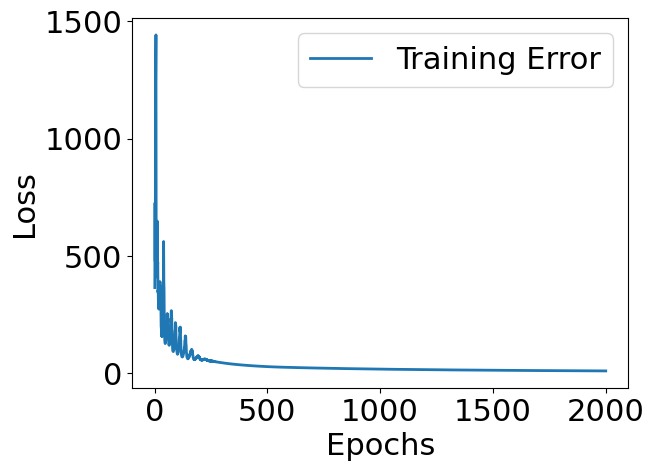

In [14]:
plt.plot(range(1, epochs+1), logis.cost_, label = "Training Error", linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Confusion Matrix

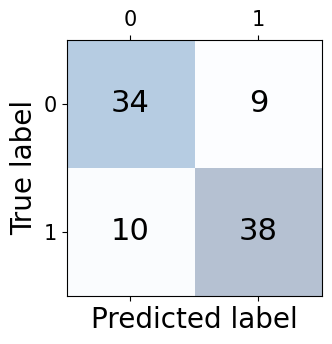

In [15]:
y_pred = logis.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

### F1 Score

In [16]:
print(f"F1 Score:\n{f1_score(y_test.values, y_pred)}")

F1 Score:
0.7999999999999999
